<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /Users/pena/crds_cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep
    from jwst.pathloss.pathloss_step import PathLossStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-031 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-055
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  1.1.22.dev0+gfd70d8d.d20211101


<a id="intro_ID"></a>
# Test Description

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- FS_ALLSLITS_G140H_F100LP 


[Top of Page](#title_ID)

In [5]:
testing_data = {
                
                'fs_allslits_g140h_f100lp':{
                                  'uncal_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None }
                                
               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1
Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp44p0jiiy/fs_allslits_g140h_f100lp_nrs1_uncal.fits


2022-09-26 10:58:38,379 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2022-09-26 10:58:38,418 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-26 10:58:38,420 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-26 10:58:38,421 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-26 10:58:38,423 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-26 10:58:38,425 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-26 10:58:38,428 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-26 10:58:38,432 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-26 10:58:38,434 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-26 10:58:38,436 - stpipe.Detector1

2022-09-26 10:58:39,191 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0024.fits'.
2022-09-26 10:58:39,192 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2022-09-26 10:58:39,193 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0006.fits'.
2022-09-26 10:58:39,194 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-09-26 10:58:39,195 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-09-26 10:58:39,196 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2022-09-26 10:58:39,197 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0010.fits'.
2022-09-26 10:58:39,198 - stpipe.Detect

2022-09-26 10:58:53,222 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0008.fits
2022-09-26 10:58:56,157 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2022-09-26 10:58:56,343 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).
2022-09-26 10:58:56,344 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp44p0jiiy', 'dark_output': None}
2022-09-26 10:58:56,381 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK referen

2022-09-26 11:18:52,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9 pixels with at least one CR from three groups.
2022-09-26 11:20:57,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:
2022-09-26 11:20:57,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496084 pixels with at least one CR from five or more groups.
2022-09-26 11:20:57,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48 pixels with at least one CR from four groups.
2022-09-26 11:20:57,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16 pixels with at least one CR from three groups.
2022-09-26 11:22:35,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:
2022-09-26 11:22:35,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500227 pixels with at least one CR from five or more groups.
2022-09-26 11:22:35,644 - stpip

2022-09-26 11:55:47,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5 pixels with at least one CR from four groups.
2022-09-26 11:55:47,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.
2022-09-26 11:59:12,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2022-09-26 11:59:13,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38554 pixels with at least one CR from five or more groups.
2022-09-26 11:59:13,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.
2022-09-26 11:59:13,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.
2022-09-26 11:59:27,856 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 3628.02 sec
2022-09-26 11:59:28,046 - stpipe.Detector

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
2022-09-26 12:05:44,777 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10
2022-09-26 12:05:44,787 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 25
2022-09-26 12:05:45,412 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2022-09-26 12:05:45,969 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).
2022-09-26 12:05:45,971 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2022-09-26 12:05:49,842 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-09-26 12:05:49,854 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.184519149 -45.685298792 156.183675453 -45.684484578 156.183609578 -45.684518640 156.184453260 -45.685332865
2022-09-26 12:05:49,856 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.184519149 -45.685298792 156.183675453 -45.684484578 156.183609578 -45.684518640 156.184453260 -45.685332865
2022-09-26 12:05:50,213 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S400A1
2022-09-26 12:05:50,213 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 573 2048
2022-09-26 12:05:50,214 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 83 137
2022-09-26 12:05:50,518 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2022-09-26 12:05:50,533 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.187759056 -45.682331806 156.186793281 -45.681401531 156.186663358

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: G140H   Filter: F100LP   Lamp: NO_LAMP   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


/Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:304: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  hdul = fits.open(reffile2use)


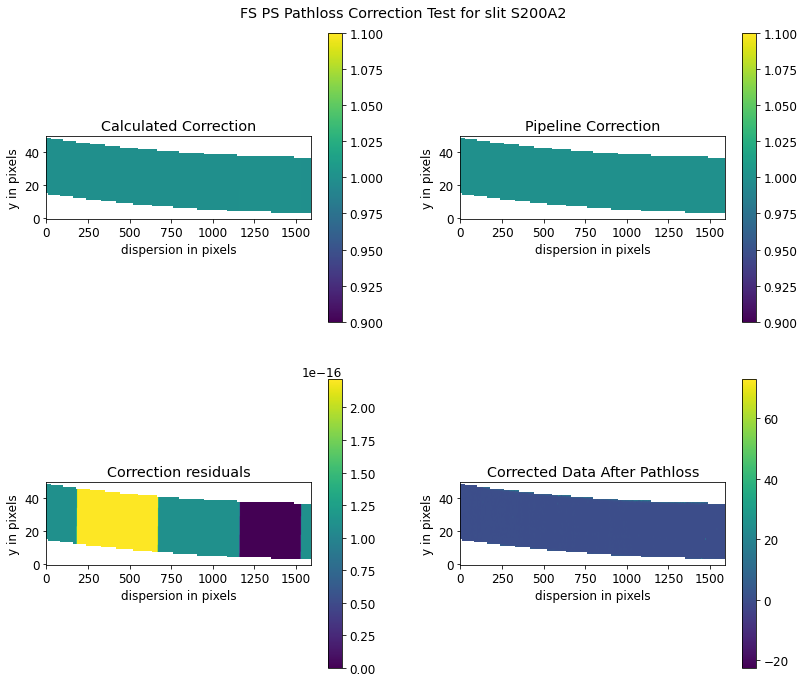

Calculating statistics... 

   Absolute Difference  :   mean = 1.193e-16    median = 1.110e-16    stdev = 8.104e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source ext

<Figure size 432x288 with 0 Axes>

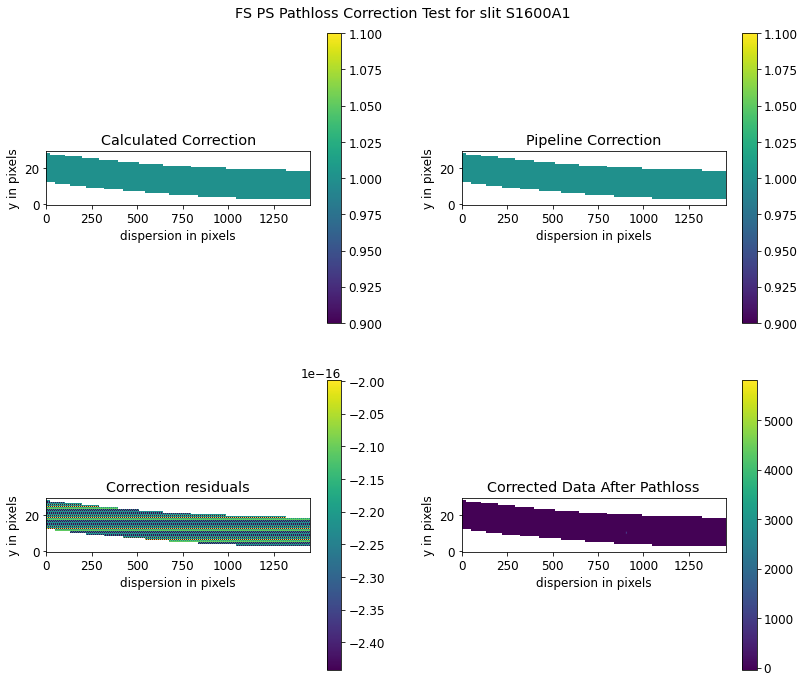

Calculating statistics... 

   Absolute Difference  :   mean = -2.220e-16    median = -2.220e-16    stdev = 0.000e+00
    Maximum   AbsoluteDifference = -2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.207915417353312 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2


<ipython-input-7-0d9ed2d3e8c4>:62: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(


Working with uncal_file:  /private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp44p0jiiy/fs_allslits_g140h_f100lp_nrs2_uncal.fits


2022-09-26 12:09:51,000 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf
2022-09-26 12:09:51,032 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-09-26 12:09:51,034 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-09-26 12:09:51,037 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-09-26 12:09:51,039 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-09-26 12:09:51,041 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-09-26 12:09:51,043 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-09-26 12:09:51,045 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-09-26 12:09:51,048 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-09-26 12:09:51,050 - stpipe.Detector1

2022-09-26 12:09:52,002 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0025.fits'.
2022-09-26 12:09:52,003 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2022-09-26 12:09:52,004 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0007.fits'.
2022-09-26 12:09:52,005 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-09-26 12:09:52,005 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2022-09-26 12:09:52,006 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2022-09-26 12:09:52,007 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0011.fits'.
2022-09-26 12:09:52,008 - stpipe.Detect

2022-09-26 12:10:06,377 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0009.fits
2022-09-26 12:10:08,484 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2022-09-26 12:10:08,710 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).
2022-09-26 12:10:08,711 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/private/var/folders/62/jxd06t_15f5_4zsxs5zrgdfm0004vc/T/tmp44p0jiiy', 'dark_output': None}
2022-09-26 12:10:08,745 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK referen

2022-09-26 12:28:24,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.
2022-09-26 12:30:17,578 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:
2022-09-26 12:30:18,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 198020 pixels with at least one CR from five or more groups.
2022-09-26 12:30:18,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.
2022-09-26 12:30:18,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11 pixels with at least one CR from three groups.
2022-09-26 12:31:06,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:
2022-09-26 12:31:06,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 459455 pixels with at least one CR from five or more groups.
2022-09-26 12:31:06,794 - stpipe

2022-09-26 12:42:15,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.
2022-09-26 12:42:15,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6 pixels with at least one CR from three groups.
2022-09-26 12:42:42,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2022-09-26 12:42:43,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359800 pixels with at least one CR from five or more groups.
2022-09-26 12:42:43,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from four groups.
2022-09-26 12:42:43,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1 pixels with at least one CR from three groups.
2022-09-26 12:44:07,566 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2035.57 sec
2022-09-26 12:44:07,702 - stpipe.Detecto

/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)
2022-09-26 12:49:00,261 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10
2022-09-26 12:49:00,267 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 25
2022-09-26 12:49:00,801 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2022-09-26 12:49:01,290 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).
2022-09-26 12:49:01,293 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2022-09-26 12:49:03,743 - stpipe.Extract2dStep - INFO - Results used CRDS context: jwst_0986.pmap
2022-09-26 12:49:03,743 - stpipe.Extract2dStep - INFO - Step Extract2dStep done
2022-09-26 12:49:03,761 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2022-09-26 12:49:03,876 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).
2022-09-26 12:49:03,878 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}
2022-09-26 12:49:03,890 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_FIXEDSLIT
2022-09-26 12:49:03,891 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = UNKNOWN
2022-09-26 12:49:03,892 - stpipe.

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: G140H   Filter: OPAQUE   Lamp: NO_LAMP   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


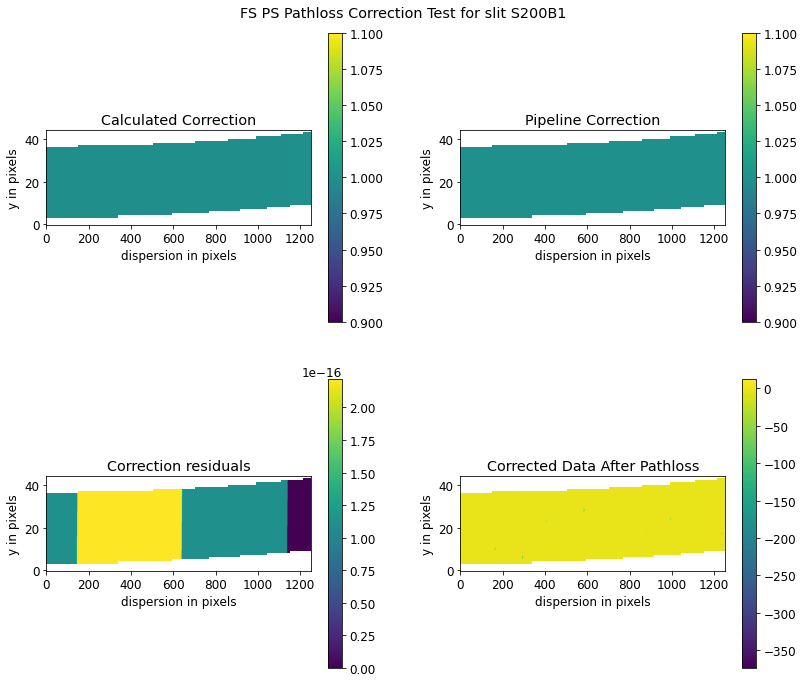

Calculating statistics... 

   Absolute Difference  :   mean = 1.451e-16    median = 1.110e-16    stdev = 6.952e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '57.84890294075012 seconds to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 




<ipython-input-7-0d9ed2d3e8c4>:62: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents'>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(


<Figure size 432x288 with 0 Axes>

In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other NPTT variables
writefile = False
show_figs = True
save_figs = False

# Get the data
detectors = ['nrs1', 'nrs2']
results_dict = {}
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
        if msa_shutter_config is not None:
            rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
            print('MSA shutter configuration file: ', rate_object.meta.instrument.msa_metadata_file)

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print('An error occurred that made the pipeline crash, probably: No open slits fall on detector ', det)
            print("Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:                        
            if 'ifu' in uncal_basename.lower() or 'mos' in uncal_basename.lower():
                pipe_object = MSAFlagOpenStep.call(pipe_object)
            if 'ifu' not in uncal_basename.lower():
                pipe_object = Extract2dStep.call(pipe_object)
            pipe_object = SourceTypeStep.call(pipe_object)
            pipe_object = WavecorrStep.call(pipe_object)
            flat_field_object = FlatFieldStep.call(pipe_object)
            pathloss_object = PathLossStep.call(flat_field_object)

            # get the corresponding reference file from the pathloss datamodel
            reffile_path = pathloss_object.meta.ref_file.pathloss.name.replace("crds://", 
                                                    "https://jwst-crds.stsci.edu/unchecked_get/references/jwst/")

            # Run the validation test
            %matplotlib inline

            if 'fs' in uncal_file.lower():
                print('Running test for FS...')
                
                source_type = pathloss_object.meta.target.source_type
                
                if source_type == 'POINT' or source_type is None:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

            if 'mos' in uncal_file.lower():
                print('Running test for MOS...')
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)

            if 'ifu' in uncal_file.lower():
                print('Running test for IFU...')

                if pathloss_object.meta.target.source_type == 'POINT':
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile,
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)
                else:
                    median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                         flat_field_object, 
                                                                                         reffile_path,
                                                                                         pathloss_object,
                                                                                         writefile=writefile, 
                                                                                         show_figs=show_figs,
                                                                                         save_figs=save_figs,
                                                                                         threshold_diff=threshold_diff)

        else:
            result_msg = 'skipped'

        # Did the test passed 
        print("Did pathloss validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result_msg}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
fs_allslits_g140h_f100lp_nrs1_uncal.fits   All slits PASSED path_loss test.
fs_allslits_g140h_f100lp_nrs2_uncal.fits   All slits PASSED path_loss test.


/Users/pena/anaconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 